In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import string
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Last Date:  2017-08-23
Start Date:  2016-08-23
Query:  SELECT measurement.date, measurement.prcp 
FROM measurement 
WHERE measurement.date >= :date_1 AND measurement.date <= :date_2
            prcp
date            
2016-08-23  0.00
2016-08-23   NaN
2016-08-23  1.79
2016-08-23  0.05
2016-08-23  0.15
...          ...
2017-08-22  0.00
2017-08-23  0.00
2017-08-23  0.00
2017-08-23  0.08
2017-08-23  0.45

[2230 rows x 1 columns]


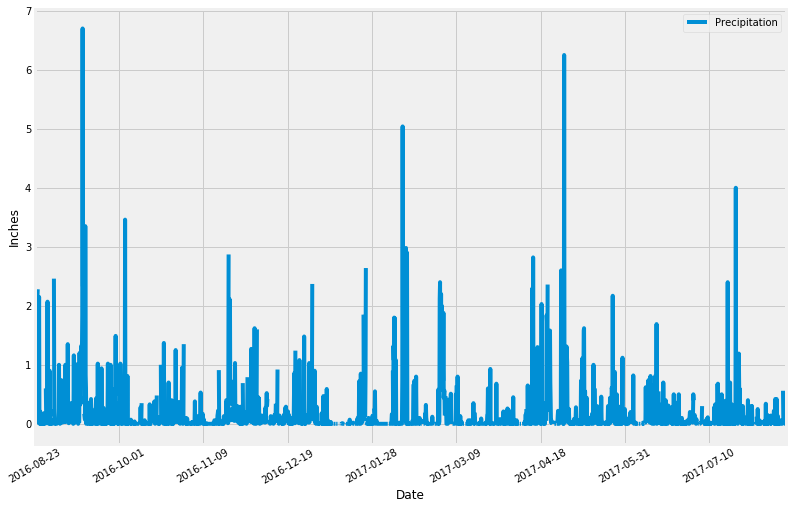

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database


from datetime import datetime

lastdate = (session.query(Measurement.date)
                .order_by(Measurement.id.desc())).first()
lastdate = str(lastdate)
lastdate = lastdate.replace("('","")
lastdate = lastdate.replace("',)","")
last_date = datetime.strptime(lastdate, "%Y-%m-%d")
last_date = datetime.date(last_date)

print("Last Date: ", last_date)

start_date = last_date - dt.timedelta(days=365)
print("Start Date: ", start_date)

# Perform a query to retrieve the data and precipitation scores
sql_query = (session.query(Measurement.date, Measurement.prcp)
                .filter(Measurement.date >= start_date)
                .filter(Measurement.date <= last_date))
print('Query: ',sql_query.statement)


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(sql_query.statement, con=engine)
#print(df)
df = df.set_index('date')
#print(df)

# Sort the dataframe by date
df1 = df.sort_index()
print(df1)

# Use Pandas Plotting with Matplotlib to plot the data
df1.plot(figsize=(12,8))
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.ylabel('Inches')
plt.legend(["Precipitation"])
plt.savefig('Images/Barplot.png')
plt.show()

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(df1.describe())
mean = df1.mean()
median = df1.median()
variance = df1.var()
std_dev = df1.std()
std_err = df1.sem()
summary_table = pd.DataFrame({"Mean":mean,
                              "Median":median,
                              "Variance":variance,
                              "Std. Dev.":std_dev,
                              "Std. Err.":std_err})
print(summary_table)

              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000
          Mean  Median  Variance  Std. Dev.  Std. Err.
prcp  0.177279    0.02  0.212696    0.46119   0.010259


In [11]:
# Design a query to show how many stations are available in this dataset

from sqlalchemy import distinct

stations_count = session.query(func.count(distinct(Measurement.station))).scalar()
print('Count of Stations: ',stations_count)
station_count = session.query(func.count(distinct(Station.station))).scalar()
print('Number of Staions: ',station_count)

Count of Stations:  9
Number of Staions:  9


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = (session.query(Measurement.station,func.count(Measurement.station).label('observation_count'))
                          .group_by(Measurement.station))
print('Query: ',active_stations.statement)

# Save the query results as a Pandas DataFrame 
stations_df = pd.read_sql_query(active_stations.statement, con=engine)

# List the stations and the counts in descending order
stations_df = stations_df.sort_values(by='observation_count', ascending=False)
print(stations_df)

Query:  SELECT measurement.station, count(measurement.station) AS observation_count 
FROM measurement GROUP BY measurement.station
       station  observation_count
6  USC00519281               2772
7  USC00519397               2724
1  USC00513117               2709
8  USC00519523               2669
3  USC00516128               2612
2  USC00514830               2202
0  USC00511918               1979
4  USC00517948               1372
5  USC00518838                511


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station = stations_df['station'].iloc[0]
lowest_temp = session.query(func.min(Measurement.tobs)).filter_by(station=active_station).scalar()
print("Lowest Temperature: "+ str(lowest_temp))
highest_temp = session.query(func.max(Measurement.tobs)).filter_by(station=active_station).scalar()
print("Highest Temperature: "+ str(highest_temp))
avg_temp = session.query(func.avg(Measurement.tobs)).filter_by(station=active_station).scalar()
print("Average Temperature: "+ str(avg_temp))

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [14]:
# Choose the station with the highest number of temperature observations.

tobs_stations = (session.query(Measurement.station,func.count(Measurement.tobs).label('tobs_count'))
                          .group_by(Measurement.station))
print('Query: ',tobs_stations.statement)

# Save the query results as a Pandas DataFrame 
tobs_df = pd.read_sql_query(tobs_stations.statement, con=engine)

# List the stations and the counts in descending order
tobs_df = tobs_df.sort_values(by='tobs_count', ascending=False)
print(tobs_df)

tobs_station = tobs_df['station'].iloc[0]
tobs_ct = tobs_df['tobs_count'].iloc[0]
result = session.query(Station).filter_by(station=tobs_station).all()
for row in result:
    location = row.name
print("--------------------------------------------------------------------------------------------------------------------")
print("Station "+tobs_station+" in "+location+" has the highest number of temperature observations with a count of "+str(tobs_ct))
print("--------------------------------------------------------------------------------------------------------------------")

most_active_station = (session.query(Measurement.station,func.count(Measurement.station).label('observation_count'))
                          .group_by(Measurement.station)
                          .order_by(func.count(Measurement.station).desc())).first()

print("Most Active Station:" +str(most_active_station))

Query:  SELECT measurement.station, count(measurement.tobs) AS tobs_count 
FROM measurement GROUP BY measurement.station
       station  tobs_count
6  USC00519281        2772
7  USC00519397        2724
1  USC00513117        2709
8  USC00519523        2669
3  USC00516128        2612
2  USC00514830        2202
0  USC00511918        1979
4  USC00517948        1372
5  USC00518838         511
--------------------------------------------------------------------------------------------------------------------
Station USC00519281 in WAIHEE 837.5, HI US has the highest number of temperature observations with a count of 2772
--------------------------------------------------------------------------------------------------------------------
Most Active Station:('USC00519281', 2772)


Query:  SELECT measurement.tobs 
FROM measurement 
WHERE measurement.date >= :date_1 AND measurement.date <= :date_2 AND measurement.station = :station_1


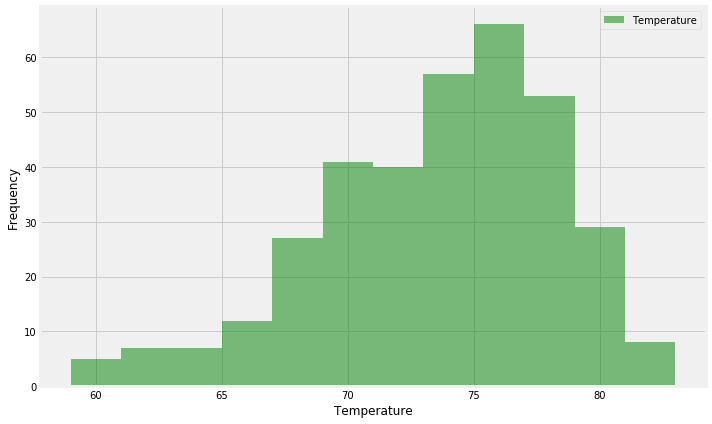

In [15]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_query = (session.query(Measurement.tobs)
                .filter(Measurement.date >= start_date)
                .filter(Measurement.date <= last_date)
                .filter_by(station=tobs_station))
print('Query: ',temp_query.statement)

# Save the query results as a Pandas DataFrame
temp_df = pd.read_sql_query(temp_query.statement, con=engine)
#print(temp_df)
temp_df.plot.hist(bins=12,color='green',alpha=0.5,figsize=(10,6))
plt.xlabel('Temperature')
plt.legend(["Temperature"])
plt.tight_layout()
plt.savefig('Images/Histogram.png')
plt.show()

# Bonus Challenge Assignment

### Temperature Analysis I

In [16]:
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import sem

# Identify average temperature in June at all stations across all available years in the dataset

june_temp_query = (session.query(Measurement.station, Measurement.tobs)
                                 .filter(func.strftime("%m", Measurement.date) == "06"))
print('Query: ',june_temp_query.statement) 

# Save the query results as a Pandas DataFrame
june_df = pd.read_sql_query(june_temp_query.statement, con=engine)
#print(june_df)
print("Average Temperature in June:" +str(round(june_df.tobs.mean(),2)))
print("June variance: "+str(sem(june_df.tobs)))

print("--------------------------------------------------------------------------------------------------------------------")
dec_temp_query = (session.query(Measurement.station, Measurement.tobs)
                                 .filter(func.strftime("%m", Measurement.date) == "12"))
print('Query: ',dec_temp_query.statement)

# Save the query results as a Pandas DataFrame
dec_df = pd.read_sql_query(dec_temp_query.statement, con=engine)
#print(dec_df)
print("Average Temperature in December:" +str(round(dec_df.tobs.mean(),2)))
print("December variance: "+str(sem(dec_df.tobs)))

# Calculate Independent (Two Sample) T-Test
stats.ttest_ind(june_df.tobs, dec_df.tobs, equal_var=False)

Query:  SELECT measurement.station, measurement.tobs 
FROM measurement 
WHERE strftime(:strftime_1, measurement.date) = :strftime_2
Average Temperature in June:74.94
June variance: 0.07900396806275338
--------------------------------------------------------------------------------------------------------------------
Query:  SELECT measurement.station, measurement.tobs 
FROM measurement 
WHERE strftime(:strftime_1, measurement.date) = :strftime_2
Average Temperature in December:71.04
December variance: 0.09617577341524217


Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

Since the means are not the same, we use the paired sample t-test which compares the means from the same group (i.e., temperatures observations) at different times (in June and December). 
The larger t-score of 31.355 and a small p value indicates that there is more difference between the two groups or that the average temperatures in June and December in Hawaii are statistically different.

### Temperature Analysis II

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Assuming my trip was from "2018-03-03" to "2018-03-12", matching dates from the 
# previous year are "2017-03-03" and "2017-03-12".
prev_start_date = '2017-03-03'
prev_end_date = '2017-03-12'
prev_temps = calc_temps(prev_start_date, prev_end_date)
print(prev_temps)
[(tmin, tavg, tmax)] = prev_temps
print("Minimum temperature: "+str(tmin))
print("Average temperature: "+str(tavg))
print("Maximum temperature: "+str(tmax))

[(62.0, 71.0, 82.0)]
Minimum temperature: 62.0
Average temperature: 71.0
Maximum temperature: 82.0


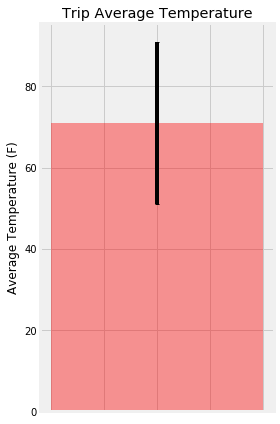

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = tmax - tmin 
fig, ax = plt.subplots(figsize=(4,6))
ax.bar(1, tavg, yerr=yerr, align='center', color ='red', alpha=0.4, ecolor='black', capsize=2)
ax.margins(0.05)
ax.set_ylabel('Average Temperature (F)')
ax.set_xticklabels([])
ax.set_title('Trip Average Temperature')

# Save the figure and show
plt.tight_layout()
plt.savefig('Images/Barplot_error_bars.png')
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Assuming my trip was from "2018-03-03" to "2018-03-12", matching dates from the 
# previous year are "2017-03-03" and "2017-03-12".

sel = [func.sum(Measurement.prcp).label('Total_rainfall'),Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
rain_query = (session.query(*sel)
                            .filter(Measurement.station == Station.station)
                            .filter(Measurement.date >= prev_start_date)
                            .filter(Measurement.date <= prev_end_date)
                            .group_by(Measurement.station)
                            .order_by(func.sum(Measurement.prcp).desc()))
print('Query: ',rain_query.statement)

# Save the query results as a Pandas DataFrame
rain_df = pd.read_sql_query(rain_query.statement, con=engine)
print(rain_df)

Query:  SELECT sum(measurement.prcp) AS "Total_rainfall", measurement.station, station.name, station.latitude, station.longitude, station.elevation 
FROM measurement, station 
WHERE measurement.station = station.station AND measurement.date >= :date_1 AND measurement.date <= :date_2 GROUP BY measurement.station ORDER BY sum(measurement.prcp) DESC
   Total_rainfall      station                                    name  \
0            2.11  USC00513117                    KANEOHE 838.1, HI US   
1            1.40  USC00519281                     WAIHEE 837.5, HI US   
2            0.92  USC00516128            MANOA LYON ARBO 785.2, HI US   
3            0.82  USC00519397                    WAIKIKI 717.2, HI US   
4            0.63  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US   
5            0.25  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US   
6            0.14  USC00517948                       PEARL CITY, HI US   

   latitude  longitude  elevation  
0  21.42340 -157.80150

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

# Assuming my trip was from "2018-03-03" to "2018-03-12"

trip_start_date = "2018-03-03"
trip_end_date = "2018-03-12"
trip_date_range = pd.date_range(start=trip_start_date, periods=10)
#print(trip_date_range)
i = 0
trip_dates = []
trip_date_labels = []
for tr_date in trip_date_range: 
    if (i <= len(trip_date_range)):
        tr_date = datetime.date(tr_date)
        tr_date = str(tr_date)
        trip_date_labels.insert(i, tr_date)
        temp_date = tr_date.lstrip('2018-')
        temp_date = '0'+temp_date
        trip_dates.insert(i, temp_date)
        i = i+1

print(trip_dates)
#print(trip_date_labels)
tmin = []
tavg = []
tmax = []
 
for i in range(0,len(trip_dates)):
    [(tmin_temp, tavg_temp, tmax_temp)] = daily_normals(trip_dates[i])
    tmin.insert(i, tmin_temp)
    tavg.insert(i, tavg_temp)
    tmax.insert(i, tmax_temp)
    
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
list_of_tuples = list(zip(tmin, tavg, tmax)) 
df1 = pd.DataFrame(list_of_tuples, index = trip_dates, columns = ['Min_Temp', 'Avg_Temp', 'Max_Temp']) 
df1.index.name = 'Date'
print(df1)

['03-03', '03-04', '03-05', '03-06', '03-07', '03-08', '03-09', '03-10', '03-11', '03-12']
       Min_Temp   Avg_Temp  Max_Temp
Date                                
03-03      60.0  70.068966      78.0
03-04      57.0  69.272727      77.0
03-05      60.0  67.890909      76.0
03-06      60.0  69.203390      76.0
03-07      60.0  69.172414      78.0
03-08      59.0  68.724138      78.0
03-09      57.0  68.561404      75.0
03-10      57.0  69.122807      75.0
03-11      60.0  69.892857      82.0
03-12      62.0  69.888889      80.0


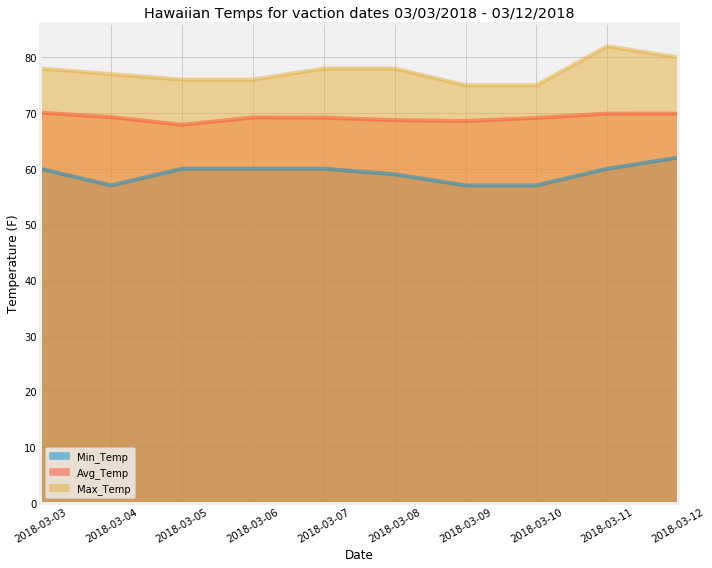

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df1.plot.area(stacked=False, figsize=(10,8))
ax.set_xlabel('Date')
plt.xticks(rotation=30)
ax.set_xticklabels(trip_date_labels)
ax.set_ylabel('Temperature (F)')
ax.set_title('Hawaiian Temps for vaction dates 03/03/2018 - 03/12/2018')
plt.tight_layout()
plt.savefig('Images/Areaplot.png')
plt.show()